# Empirical survey selection function for Gaia DR3

updated: 01 March 2023

## Completeness using the empirical Gaia DR3 selection function

Our selection function of the Gaia DR3 catalogue can be queried via class **DR3SelectionFunctionTCG**, which can be loaded in three different modes:

* 'hpx7' (default) loads a precomputed all-sky map in healpix regions of order 7

* 'multi' loads a precomputed all-sky map in healpix regions of order 7 to 10, with finer binning in denser parts of the sky

* 'patch' creates maps on the fly for a given circular region of the sky

In [1]:
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG

When we call the class, the package will look for the file **allsky_M10_hpx7.hdf5**. If it is not present, it will download it.

In [2]:
mapHpx7 = DR3SelectionFunctionTCG()

To obtain the completeness at a given point and magnitude we use the **.query()** method. The coordinates must be given as astropy objects. To quickly generate the list of coordinates of the centers of healpixels we provide the **get_healpix_centers** function. The array containing magnitudes must have the same shape as the coordinate array.

In [3]:
from gaiaunlimited.utils import get_healpix_centers
coords_of_centers = get_healpix_centers(7)
import numpy as np
gmag = np.ones_like(coords_of_centers) * 21.
print(f'Computing the completeness for {len(coords_of_centers)} points.')
completeness = mapHpx7.query(coords_of_centers,gmag)

Computing the completeness for 196608 points.


This returned an array of numbers between 0 and 1:

In [4]:
print(completeness)

[0.72350425 0.71772665 0.69901098 ... 0.69006834 0.73700795 0.67268723]


We can use healpy's **mollview** to plot the all-sky map. The healpix numbering scheme is in equatorial coordinates ('Celestial' in healpy), but for all-sky maps I prefer using Galactic coordinates:

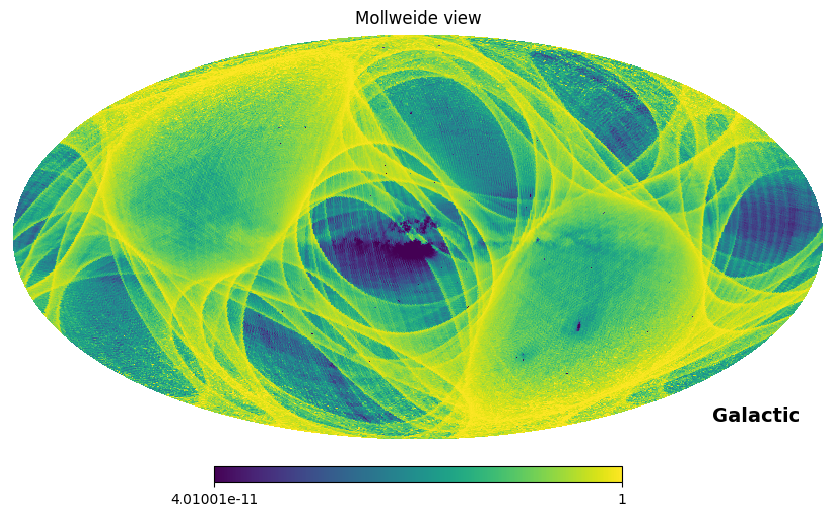

In [5]:
import healpy as hp
hp.mollview(completeness,coord=['Celestial','Galactic'])

You might recognise some features already. The stripes are caused by the Gaia scanning law. Regions with high stellar density are also visible, in the direction of the Galactic centre, or the Magellanic clouds. The presence of globular clusters is also visible, as individual healpixels of low completeness.

We can zoom in on a particular region with **gnomview**, for instance the globular cluster NGC 6752 near (ra,dec)=(288,-60).

To display a 2 degree x 2 degree field we make a plot with width of 240 pixels, and 0.5 arcminute per pixel.

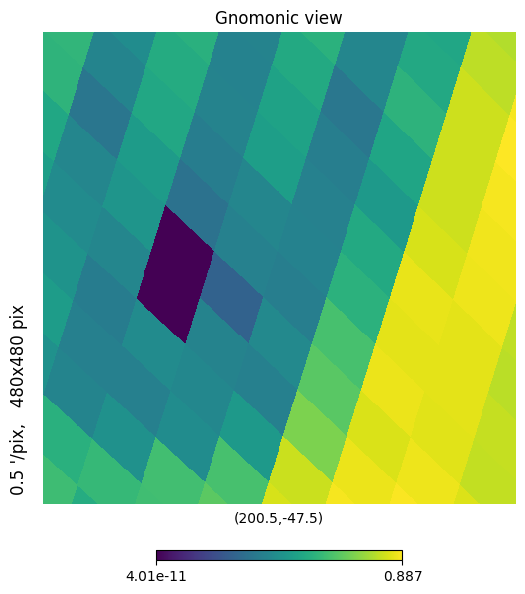

In [6]:
hp.gnomview(completeness,rot=[200.5,-47.5],xsize=480,reso=0.5)

The size of a healpix order 7 is about half a degree, which may be too coarse for some science cases.

## Higher resolution: multi-order map

Calling **DR3SelectionFunctionTCG('multi')** we load a precomputed all-sky map where the healpixel size varies with density. Here is an example around the globular cluster Omega Centauri (NGC 5139).

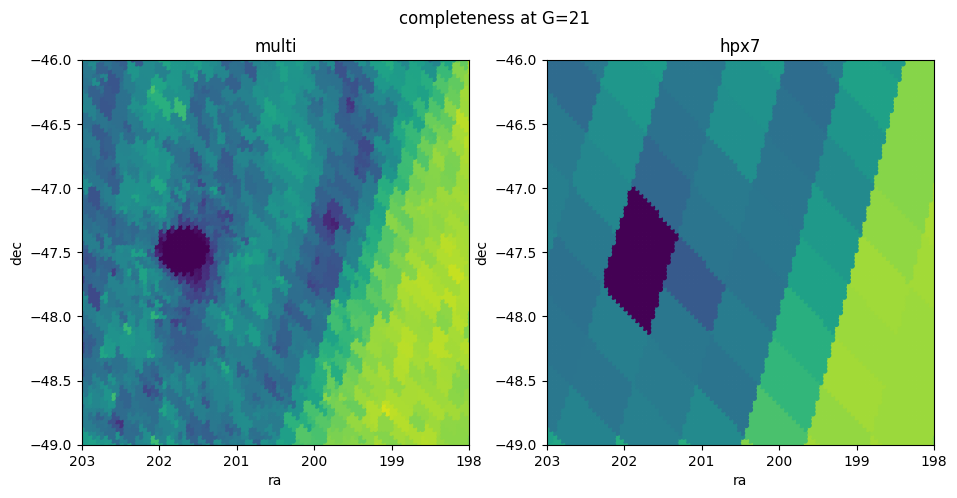

In [7]:
import matplotlib.pyplot as plt

mapMulti = DR3SelectionFunctionTCG('multi')

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

#Define grid of points to evaluate completeness:
xx =[]
yy =[]
for rr in np.linspace( 198 , 203 , 100 ):
    for dd in np.linspace( -49 , -46 , 100 ):
        xx.append(rr)
        yy.append(dd)
cc = SkyCoord(ra=xx*u.degree, dec=yy*u.degree)

#Magnitude (same for all points here):
gmag = np.ones_like(cc) * 21

completenessMultiOrder = mapMulti.query( cc , gmag )
completenessHpx7 = mapHpx7.query( cc , gmag )

plt.figure(figsize=(11,5))

plt.subplot(121)
plt.title('multi')
plt.scatter( xx , yy , c=completenessMultiOrder, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)
plt.subplot(122)
plt.title('hpx7')
plt.scatter( xx , yy , c=completenessHpx7, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

plt.suptitle('completeness at G=21');

The multiorder map has a finer resolution, especially around the cluster.

##### Creating a high-resolution map of a specific region

**This queries the Gaia archive using the astroquery package.**

We provide a way to initialise the model map for a small region of the sky (a few square degrees are still manageable). The map will employ healpixels of level 6 to 12, providing a finer resolution in the denser areas. 

**<font color='orange'>NOTE:</font> In this example we use a radius of 1.5 degrees. The queries are quick but organising the multi-order map takes about two minutes.**

At present this only creates circular patches, centered on a (ra,dec) position specified by the user, with a radius given in degrees. The coordinates of the center must be given as an astropy **SkyCoord** object.

In [8]:
%%time
coordCenter = SkyCoord(ra=200.5,dec=-47.5,unit='deg',frame='icrs')
mapPatch = DR3SelectionFunctionTCG( 'patch' , coordCenter , 1.5 )

Querying the Gaia archive...
SELECT ra, dec, source_id,phot_g_mean_mag
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(POINT(ra,dec),CIRCLE(200.500000, -47.500000, 1.500000))
    and astrometric_matched_transits<11
    and phot_g_mean_mag<50
INFO: Query finished. [astroquery.utils.tap.core]
Obtained 91526 sources.
Grouping the stars by hpx level 12...


/opt/anaconda3/envs/GU/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Grouping the stars by hpx level 11...
Grouping the stars by hpx level 10...
Grouping the stars by hpx level 9...
Grouping the stars by hpx level 8...
Done.
CPU times: user 1min 46s, sys: 537 ms, total: 1min 47s
Wall time: 1min 52s


The completeness is evaluated from the median magnitude of sources with fewer than 10 matched transits. By default, the map requires at least 20 such sources per spatial bin. If we lower this requirement we can make higher-resolution (but noisier) maps:

In [ ]:
%%time
mapPatch_higherRes = DR3SelectionFunctionTCG( 'patch' , coordCenter , 1.5 , min_points=5)

Querying the Gaia archive...
SELECT ra, dec, source_id,phot_g_mean_mag
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(POINT(ra,dec),CIRCLE(200.500000, -47.500000, 1.500000))
    and astrometric_matched_transits<11
    and phot_g_mean_mag<50
INFO: Query finished. [astroquery.utils.tap.core]
Obtained 91526 sources.
Grouping the stars by hpx level 12...
Grouping the stars by hpx level 11...
Grouping the stars by hpx level 10...


In [ ]:
plt.figure(figsize=(11,11))

completenessPatch = mapPatch.query(cc , gmag)
completenessPatch_higherRes = mapPatch_higherRes.query(cc , gmag)

plt.subplot(221)
plt.title('multi')
plt.scatter( xx , yy , c=completenessMultiOrder, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

plt.subplot(222)
plt.title('hpx7')
plt.scatter( xx , yy , c=completenessHpx7, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

plt.subplot(223)
plt.title('patch (default: min_points=20)')
plt.scatter( xx , yy , c=completenessPatch, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

plt.subplot(224)
plt.title('patch (min_points=5)')
plt.scatter( xx , yy , c=completenessPatch_higherRes, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

plt.suptitle('completeness at G=21');

## Comparing 'multi' and 'patch' in a very dense region

The 'multi' map and the 'patch' (min_points=20) maps look very similar, because the multi-order map was computed for the entire sky with the requirement that healpix regions must have at least 20 sources to compute the completeness. However, it was only computed down to order 10, which means the 'patch' maps can have a finer resolution in dense regions.

In [ ]:
clusterCentre = SkyCoord(ra=201.7,dec=-47.5,unit='deg',frame='icrs')
mapPatch_ngc5139 = DR3SelectionFunctionTCG( 'patch' , clusterCentre , 0.25 )

In [ ]:
#Define grid of points to evaluate completeness:
xx =[]
yy =[]
for rr in np.linspace( 201.4 , 202 , 100 ):
    for dd in np.linspace( -47.8 , -47.2 , 100 ):
        xx.append(rr)
        yy.append(dd)
cc = SkyCoord(ra=xx*u.degree, dec=yy*u.degree)

#Magnitude (same for all points here):
gmag = np.ones_like(cc) * 17

completenessMultiOrder = mapMulti.query( cc , gmag )
completenessPatch_ngc5139 = mapPatch_ngc5139.query( cc , gmag )

plt.figure(figsize=(11,5))

plt.subplot(121)
plt.title('multi')
plt.scatter( xx , yy , c=completenessMultiOrder, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(202,201.4); plt.ylim(-47.8,-47.2)

plt.subplot(122)
plt.title('patch')
plt.scatter( xx , yy , c=completenessPatch_ngc5139, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(202,201.4); plt.ylim(-47.8,-47.2)

plt.suptitle('completeness at G=17');

## Evaluate the completeness along a line going through the cluster

In [ ]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

ra = np.linspace(202.5,200.5,30)
dec = -47.45 * np.ones_like(ra)

cc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)


import matplotlib.pyplot as plt
plt.figure(0)
for g in [17,18,19,20,21,21.1,21.2]:
    completenessGCslice = mapPatch_higherRes.query(cc,g*np.ones_like(cc))
    plt.plot( cc.ra.degree , completenessGCslice , label='G = %.1f' % (g))
plt.legend(loc='upper right')
plt.xlim(max(cc.ra.degree),min(cc.ra.degree))
plt.xlabel('ra (degrees)')
plt.ylabel('completeness');

## More advanced: mapping $M_{10}$

Here we show what is happening under the hood when a map is computed.

To be included in the Gaia catalogue, a source must have detected at least five times by Gaia. This number is given as **astrometric_matched_transits** in the Gaia DR3 source table. By looking at the magnitude of the sources with the smallest number of astrometric_matched_transits, we can make relatively good completeness predictions.

Our model predicts the completeness of a given patch of sky, based on the *median G magnitude* of the sources with *ten or fewer* astrometric matched transits. We call this computed quantity: $M_{10}$

Let's take a look at the region around NGC 6752.

In [ ]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1  # default is 50 rows max, -1 for unlimited

ra = 288
dec = -60
size=2

scale = 1.0 / np.cos(np.radians(dec))
queryStringGaia = """SELECT ra, dec, source_id,phot_g_mean_mag
        FROM gaiadr3.gaia_source 
        WHERE ra>%.3f and ra<%.3f
        and dec>%.3f and dec<%.3f
        and astrometric_matched_transits<11
        and phot_g_mean_mag<50""" % (
            ra - scale * size / 2,
            ra + scale * size / 2,
            dec - size / 2,
            dec + size / 2,
        )

job = Gaia.launch_job_async(queryStringGaia)
GaiaT = job.get_results()
print(f"{len(GaiaT)} sources downloaded.")

In [ ]:
fig=plt.figure(0,figsize=(15,6))
ax=fig.add_subplot(121,aspect=scale)
plt.scatter( GaiaT['ra'] , GaiaT['dec'] , c=GaiaT['phot_g_mean_mag'] , vmin=20.5, vmax=21.2,s=5,cmap='turbo_r')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.colorbar(label='phot_g_mean_mag')
plt.title('all sources with\nastrometric_matched_transits <= 10')
ax.set_facecolor('black')

from scipy import stats
MAPm10, xedges, yedges, binnumber = stats.binned_statistic_2d( GaiaT['ra'], GaiaT['dec'] ,
                                                               GaiaT['phot_g_mean_mag'] ,
                                                               statistic=np.nanmedian, 
                                                               bins = 11 )
ax=fig.add_subplot(122, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, MAPm10.T,cmap='turbo_r', vmin=20.5, vmax=21.2)
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.title('median G magnitude of those sources')

This map is not a completeness map yet (although $M_{10}$ roughly correlates with the magnitude of 50% completeness). To convert $M_{10}$ to a completeness at a given magnitude, use the function: **m10_to_completeness**.

In [ ]:
from gaiaunlimited.selectionfunctions import m10_to_completeness

plt.figure(2,figsize=(8,8))

for i,g in enumerate([20.5,20.8,21,21.2]):
    plt.subplot(2,2,i+1,aspect=scale)
    plt.pcolormesh(X, Y, m10_to_completeness(g,MAPm10.T),cmap='viridis',vmin=0,vmax=1)
    plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
    plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
    if i in [0,1]:
        plt.xticks([])
    if i in [1,3]:
        plt.yticks([])
    plt.title(f'completeness at G={g}')

You can also use this to display the completeness as a function of magnitude in all pixels. Areas with values of $M_{10}$ have a higher completeness.

In [ ]:
cmap = plt.cm.turbo_r
norm = plt.Normalize(vmin=20.5, vmax=21.2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


gtoplot = np.linspace(17.5,22,100)
plt.figure(3)
for m10 in MAPm10.flatten():
    plt.plot( gtoplot , m10_to_completeness(gtoplot,m10) , color=cmap(norm(m10)))
plt.xlabel('G magnitude')
plt.ylabel('completeness')
plt.colorbar(sm).set_label('$M_{10}$')



plt.figure(4)
for m10 in MAPm10.flatten():
    plt.plot( gtoplot , m10_to_completeness(gtoplot,m10) , color=cmap(norm(m10)))
plt.xlabel('G magnitude')
plt.ylabel('completeness')
plt.xlim(20.5,21.5)
plt.colorbar(sm).set_label('$M_{10}$')



## Accessing the $M_{10}$ maps 

Internally, the maps are stored as numpy arrays of shape (n,3). The first element of each row is the healpix order. For instance, for the all-sky map in healpix order 7 we display at the beginning of this tutorial:

In [ ]:
print(mapHpx7.m10map)
print(mapHpx7.m10map.shape)

The maps made for patches use healpix order 12:

In [ ]:
print(mapPatch.m10map)
print(mapPatch.m10map.shape)

In [ ]:
print(mapPatch_higherRes.m10map)
print(mapPatch_higherRes.m10map.shape)

Since the maps are stored in a simple numpy array, they can be stored and loaded directly:

In [ ]:
np.save( 'example_saved_map.npy' , mapPatch_higherRes.m10map )

new_map = DR3SelectionFunctionTCG() # on instantiation, loads all-asky hpx7 map
new_map.m10map = np.load('example_saved_map.npy')

# And replot:
xx =[]
yy =[]
for rr in np.linspace( 198 , 203 , 100 ):
    for dd in np.linspace( -49 , -46 , 100 ):
        xx.append(rr)
        yy.append(dd)
cc = SkyCoord(ra=xx*u.degree, dec=yy*u.degree)

#Magnitude (same for all points here):
gmag = np.ones_like(cc) * 21

completeness_new = new_map.query( cc , gmag )

plt.figure(figsize=(5,5))
plt.title('patch')
plt.scatter( xx , yy , c=completeness_new, s=10, vmin=0.,vmax=1 , cmap='viridis')
plt.xlabel('ra'); plt.ylabel('dec')
plt.xlim(203,198); plt.ylim(-49,-46)

## Example of a custom-made adaptive binning with square bins

Here we query the Gaia archive and make $M_{10}$ maps of increasing resolution.

In [ ]:
ra = 288
dec = -60
size = 4 #size of the square field of view, in degree
resMax = 0.002 #minimum bin size in degree
min_points = 10 #minimum number of points per bin

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

scale=1./np.cos(np.radians(dec))
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited
queryStringGaia = """SELECT ra, dec, phot_g_mean_mag
    FROM gaiadr3.gaia_source 
    WHERE ra>%.3f and ra<%.3f
    and dec>%.3f and dec<%.3f
    and phot_g_mean_mag<50
    and astrometric_matched_transits<11""" % (ra-scale*size/2,ra+scale*size/2,dec-size/2,dec+size/2)
job = Gaia.launch_job_async(queryStringGaia)
GaiaT = job.get_results()
print( f'{len(GaiaT)} sources downloaded.')

In [ ]:
import warnings
allHcounts = []
allHmedians = []

N=0
while size/2**N > resMax:
    print('Iteration',N,'bin size is',size/2**N)

    #we first count the sources so we can evaluate if our bins are too small:
    H, xedges, yedges = np.histogram2d(GaiaT['ra'], GaiaT['dec'], bins=2**N)
    #Then compute the median.
    #We anticipate a lot of empty bins, for which np.nanmedian will return a RuntimeWarning
    #so we catch those and don't print them to screen.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        MAPm10, xedges, yedges, binnumber = stats.binned_statistic_2d( GaiaT['ra'], GaiaT['dec'] ,
                                                                       GaiaT['phot_g_mean_mag'] ,
                                                                       statistic=np.nanmedian, 
                                                                       bins = 2**N )

    MAPm10[H<min_points]=np.nan
    allHcounts.append( H )
    allHmedians.append( MAPm10 )

    N=N+1

#we use the highest available resolution:
finalMap = allHmedians[-1]
#we go through this map and find all empty pixels:
nbRows = len(finalMap)
nbCols = len(finalMap[0])

stepUp=1
while np.isnan(finalMap).any():
    print('Going up one level...',stepUp)
    for j in range(nbRows):
        for i in range(nbCols):
            if np.isnan(finalMap[j][i]):
                #print('replacing',finalMap[j][i],'with',allHmedians[-2][i//2][j//2])
                finalMap[j][i] = allHmedians[-1-1*stepUp][j//2**stepUp][i//2**stepUp]
    stepUp=stepUp+1

    
print('...done')

We can now convert the $M_{10}$ map to a completeness map at any magnitude.

In [ ]:
from gaiaunlimited.selectionfunctions import m10_to_completeness

fig = plt.figure(figsize=(17,9))

ax=fig.add_subplot(231, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, finalMap.T,cmap='turbo_r',vmin=16.5,vmax=21.2)
plt.colorbar(label='M10')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(232, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(18,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=18')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(233, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(21,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=21')
plt.xlim(max(GaiaT['ra']),min(GaiaT['ra']))
plt.ylim(min(GaiaT['dec']),max(GaiaT['dec']))
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(234, aspect=scale)
plt.title('zooming in on the cluster')
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, finalMap.T,cmap='turbo_r',vmin=16.5,vmax=21.2)
plt.colorbar(label='M10')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(235, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(18,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=18')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

ax=fig.add_subplot(236, aspect=scale)
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, m10_to_completeness(21,finalMap.T),cmap='viridis',vmin=0,vmax=1)
plt.colorbar(label='completeness at G=21')
plt.xlim(288.04,287.40)
plt.ylim(-60.15,-59.83)
plt.xlabel('ra'); plt.ylabel('dec')

plt.tight_layout()

## Interactive map

**Note: the map will only be interactive if you run the notebook locally, not in the online (static) version.**

This makes a zoomable map with a slider to change the magnitude.

The underlying **MAPm10** is a 1024 x 1024 array, so updating the figure is slow.

In [ ]:
%matplotlib notebook
from matplotlib.widgets import Slider

fig=plt.figure(figsize=(7,8))
ax=plt.subplot(111,aspect=scale)
cMap = ax.pcolormesh(X, Y, m10_to_completeness(21,MAPm10.T),cmap='viridis',vmin=0,vmax=1)
plt.xlabel('ra (degrees)')
plt.ylabel('dec (degrees)')

plt.subplots_adjust(bottom=0.2)
ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_Gmag = Slider(ax_slider,"G magnitude",valmin=20.5,valmax=21.5,valinit=21,valstep=0.1)

def update(val):
    current_G = slider_Gmag.val
    newCompletenessMap = m10_to_completeness(current_G,MAPm10.T)
    print(current_G)
    ax.pcolormesh(X, Y, newCompletenessMap,cmap='viridis',vmin=0,vmax=1)
    fig.canvas.draw()
    
slider_Gmag.on_changed(update);